## Pandana test on Grünerløkka road network

In [68]:
%load_ext watermark
%watermark
%watermark -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2024-03-07T21:03:57.955152+01:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.22.2

Compiler    : MSC v.1935 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit

Watermark: 2.4.3



In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import shapely
import geopandas as gpd
import osmnx as ox
# import networkx as nx
import pandana as pdna

# import pygeos

pd.set_option('display.float_format', lambda x: '%.3f' % x)
# gpd.options.use_pygeos = False
# print("Check if geopandas uses shapely's pygeos:", gpd.options.use_pygeos) # speed up spatial operations

%watermark -w
%watermark -iv

Watermark: 2.4.3

pandas    : 2.2.1
matplotlib: 3.8.3
geopandas : 0.14.3
osmnx     : 1.9.1
shapely   : 2.0.3
numpy     : 1.26.4
pandana   : 0.7



Shapely 2.0 comes with built in pygeos (speeds up spatial operations)   
However, one cannot use pygeos and shapely(with geos activated) together in the same environment, as they will both fight for the same C library (GEOS).  
We disable shapely's geos and use normal pygeos instead, since OSMnx use pygeos for spatial operations and will complain otherwise.


## 1. Load the data
Loading a small road network of Grünerløkka for testing.

In [70]:
### Road network file of Grünerløkka, Oslo 
# Local file paths
# gruner_filepath = "C:/Users/torha/prog.div/PiT/osmnx-oslo/data/grünerlokka_road_network.gpkg"
# gruner_filepath = "C:/Users/torha/prog.div/PiT/osmnx-oslo/data/grünerlokka_road_network.graphml"

# Fetch from OSM - using OSMnx 
gruner_graph = ox.graph_from_place('Grünerløkka, Oslo, Norway', network_type="drive_service") # originally in WGS84 (EPSG:4326)

type of gruner_graph: <class 'networkx.classes.multidigraph.MultiDiGraph'>
crs of gruner_graph:  epsg:4326


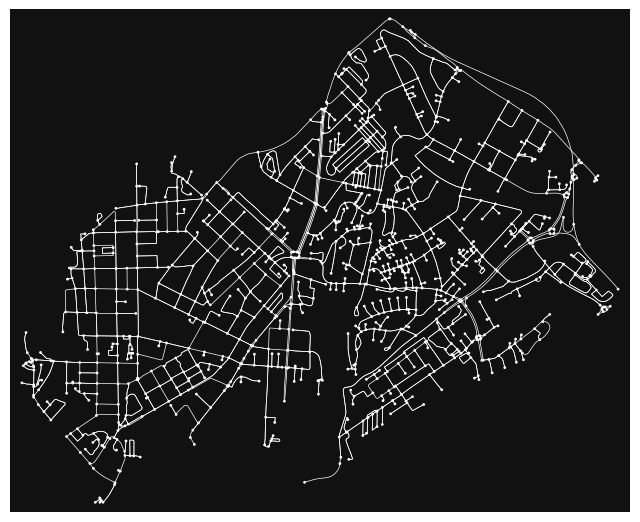

In [71]:
# print graph info
print(f"type of gruner_graph: {type(gruner_graph)}")
print(f"crs of gruner_graph:  {gruner_graph.graph['crs']}")
# plot graph
fig, ax = ox.plot_graph(gruner_graph, node_size=4, edge_linewidth=0.5, edge_color="w")

Convert graph to GeoDataFrame and plot it.   
`osmnx.utils_graph.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)` - Convert a MultiDiGraph to node and/or edge GeoDataFrames.

In [72]:
# converting the graph network to node and edge GeoPandas GeoDataFrames
nodes, edges = ox.graph_to_gdfs(gruner_graph, nodes=True, edges=True)
print(f"type of nodes:{type(nodes)}")
# nodes.head()

type of nodes:<class 'geopandas.geodataframe.GeoDataFrame'>


## 2. Impute missing edge speeds
#### Inspecting GeoDataFrames before adding edge(road) speeds

In [73]:
# converting graph to node and edge GeoPandas GeoDataFrames
edges.keys()

Index(['osmid', 'lanes', 'name', 'highway', 'oneway', 'reversed', 'length',
       'geometry', 'maxspeed', 'ref', 'junction', 'bridge', 'service', 'width',
       'access', 'tunnel'],
      dtype='object')

In [74]:
# Select a subset of columns - before imputing edge speeds
subset_columns = ['lanes', 'name', 'highway', 'oneway', 'reversed', 'length', 'maxspeed', 'ref', 'junction', 'bridge', 'width', 'tunnel']
subset_gdf = edges[subset_columns]
subset_gdf.head(4)

lanes           name    highway  oneway reversed  length  \
u     v          key                                                            
79448 3165357950 0       2  Maridalsveien  secondary   False    False 107.935   
79465 106183     0       2    Toftes gate  secondary   False     True 139.757   
      12630987   0       2    Toftes gate  secondary   False    False  99.113   
      79475      0       3     Sannergata   tertiary   False     True 111.025   

                     maxspeed  ref junction bridge width tunnel  
u     v          key                                             
79448 3165357950 0        NaN  NaN      NaN    NaN   NaN    NaN  
79465 106183     0        NaN  NaN      NaN    NaN   NaN    NaN  
      12630987   0         40  NaN      NaN    NaN   NaN    NaN  
      79475      0         40  NaN      NaN    NaN   NaN    NaN

#### Imputing edge speeds and inspecting new columns in resulting GeoDataFrame
The `add_edge_speeds` function add edge speeds (km per hour) to graph as new `speed_kph` edge attributes. Imputes free-flow travel speeds for all edges based on mean `maxspeed` value of edges, per highway type. This mean-imputation can obviously be imprecise, and the caller can override it by passing in `hwy_speeds` and/or `fallback` arguments that correspond to local speed limit standards. See docstring for details.

In [75]:
# impute speed on all edges missing data
gruner_graph = ox.speed.add_edge_speeds(gruner_graph)

# calculate travel time (seconds) for all edges
gruner_graph = ox.speed.add_edge_travel_times(gruner_graph)

# converting graph to node and edge GeoPandas GeoDataFrames
nodes, edges = ox.graph_to_gdfs(gruner_graph)
print(f"type of gruner_gdf_nodes:{type(nodes)}, shape:, {nodes.shape}")
edges.keys()
# gruner_gdf_edges.head()

type of gruner_gdf_nodes:<class 'geopandas.geodataframe.GeoDataFrame'>, shape:, (1147, 6)


Index(['osmid', 'lanes', 'name', 'highway', 'oneway', 'reversed', 'length',
       'geometry', 'speed_kph', 'travel_time', 'maxspeed', 'ref', 'junction',
       'bridge', 'service', 'width', 'access', 'tunnel'],
      dtype='object')

In [76]:
# Select a subset of columns
subset_columns = ['lanes', 'name', 'highway', 'oneway', 'reversed', 'length', 'speed_kph', 'travel_time', 'maxspeed', 
                  'ref', 'junction', 'bridge', 'service', 'width', 'access', 'tunnel']
subset_gdf = edges[subset_columns]
subset_gdf.head(4)

lanes           name    highway  oneway reversed  length  \
u     v          key                                                            
79448 3165357950 0       2  Maridalsveien  secondary   False    False 107.935   
79465 106183     0       2    Toftes gate  secondary   False     True 139.757   
      12630987   0       2    Toftes gate  secondary   False    False  99.113   
      79475      0       3     Sannergata   tertiary   False     True 111.025   

                      speed_kph  travel_time maxspeed  ref junction bridge  \
u     v          key                                                         
79448 3165357950 0       44.500        8.700      NaN  NaN      NaN    NaN   
79465 106183     0       44.500       11.300      NaN  NaN      NaN    NaN   
      12630987   0       40.000        8.900       40  NaN      NaN    NaN   
      79475      0       40.000       10.000       40  NaN      NaN    NaN   

                     service width access tunnel  
u     v          key                              
79448 3165357950 0       NaN   NaN    NaN    NaN  
79465 106183     0       NaN   NaN    NaN    NaN  
      12630987   0       NaN   NaN    NaN    NaN  
      79475      0       NaN   NaN    NaN    NaN

The majority of the roads have an imputed road speed of 30 km/h, while the highest road speed is 70 km/h.

In [77]:
# Export the graph with imputed edge speeds to file
ox.io.save_graphml(gruner_graph, filepath="GrunerGraphTravelTime.graphml", gephi=False, encoding='utf-8')

# load the graph from file
# gruner_graph99 = ox.io.load_graphml("GrunerGraphTravelTime.graphml")

## 3. Define the origin and destination points

In [78]:
# set seed for reproducibility
seed = 42
nodes_sample = nodes.sample(1010, random_state=seed) # sample 1000 random source nodes
facility_nodes = nodes_sample.iloc[:10] # first 10 nodes are facilities
client_nodes = nodes_sample.iloc[10:]   # rest of nodes are clients
print(f"Total nr of nodes: {len(nodes)}, nr of facility nodes: {len(facility_nodes)}, nr of client nodes: {len(client_nodes)}")
nodes_sample.head(3)

Total nr of nodes: 1147, nr of facility nodes: 10, nr of client nodes: 1000


,y,x,street_count,highway,ref,geometry
osmid,,,,,,
974588774,59.927,10.798,3,NaN,NaN,POINT (10.79778 59.92685)
11398964085,59.926,10.792,1,NaN,NaN,POINT (10.79201 59.92564)
7320861367,59.926,10.771,1,NaN,NaN,POINT (10.77053 59.92645)


In [79]:
edges.head(3)

osmid lanes           name    highway  oneway  \
u     v          key                                                      
79448 3165357950 0    129061337     2  Maridalsveien  secondary   False   
79465 106183     0      4211442     2    Toftes gate  secondary   False   
      12630987   0    349267814     2    Toftes gate  secondary   False   

                     reversed  length  \
u     v          key                    
79448 3165357950 0      False 107.935   
79465 106183     0       True 139.757   
      12630987   0      False  99.113   

                                                               geometry  \
u     v          key                                                      
79448 3165357950 0    LINESTRING (10.75082 59.92156, 10.75078 59.921...   
79465 106183     0    LINESTRING (10.76110 59.92850, 10.76110 59.928...   
      12630987   0    LINESTRING (10.76110 59.92850, 10.76110 59.928...   

                      speed_kph  travel_time maxspeed  ref junction bridge  \
u     v          key                                                         
79448 3165357950 0       44.500        8.700      NaN  NaN      NaN    NaN   
79465 106183     0       44.500       11.300      NaN  NaN      NaN    NaN   
      12630987   0       40.000        8.900       40  NaN      NaN    NaN   

                     service width access tunnel  
u     v          key                              
79448 3165357950 0       NaN   NaN    NaN    NaN  
79465 106183     0       NaN   NaN    NaN    NaN  
      12630987   0       NaN   NaN    NaN    NaN

## 4. Define the Pandana network

Now we use the GeoDataFrames from `osmnx` to create a `pandana` network.

Pandana networks is defined like this:   
`pandana.network.Network(node_x, node_y, edge_from, edge_to, edge_weights, twoway=True)`  

 **edge_weights**: DataFrame, all numerics   
- Specifies one or more impedances on the network which define the distances between nodes.  
- Multiple impedances can be used to capture travel times at different times of day, for instance.

We will use both ``length`` and ``travel_time`` as edge weights. However, we must specify which one to use when querying the network (cannot calculate with both at the same time).

In [80]:
# reset index so our origins and destinations are not in index
edges = edges.reset_index()

# create network with pandana
gruner_pandana_network = pdna.Network(node_x=nodes['x'], node_y=nodes['y'], edge_from=edges['u'], edge_to=edges['v'], 
                                      edge_weights=edges[["length", "travel_time"]], twoway=True)

# Print stats about the network
print(f"type of gruner_pandana_network: {type(gruner_pandana_network)}")
print(f"Network nodes:")
gruner_pandana_network.nodes_df.head(3)

type of gruner_pandana_network: <class 'pandana.network.Network'>
Network nodes:


,x,y
osmid,,
79448,10.751,59.922
79465,10.761,59.928
79475,10.759,59.928


In [81]:
print(f"Network edges: ")
gruner_pandana_network.edges_df.head(3)

Network edges: 


,from,to,length,travel_time
0,79448,3165357950,107.935,8.700
1,79465,106183,139.757,11.300
2,79465,12630987,99.113,8.900


Here we verify that the Pandana network has the correct edge weights. In this case, both length and travel_time.

Next, it’s probably a good idea (though not strictly required) to precompute a given horizon distance so that aggregations don’t perform the network queries unnecessarily.   
This is done by calling the following code, where 3000 meters is used as the horizon distance:

In [82]:
gruner_pandana_network.precompute(3000)

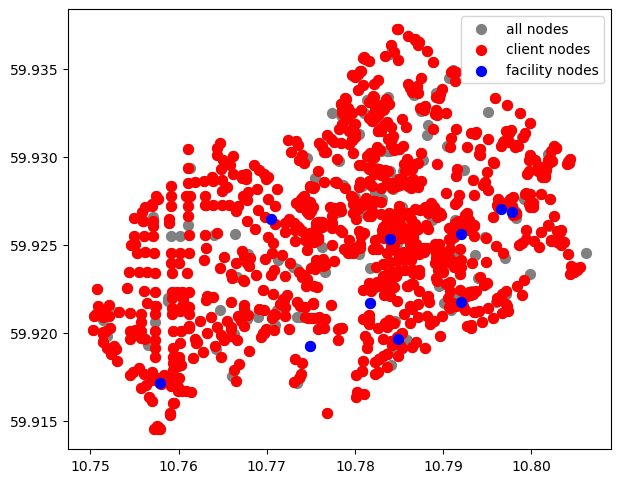

In [83]:
# Plot nodes for overview
fig, ax = plt.subplots(figsize=(7, 7))
nodes.plot(ax=ax, color='gray', markersize=10)
client_nodes.plot(ax=ax, color='r', markersize=10)
facility_nodes.plot(ax=ax, color='b', markersize=50)
ax.legend(['all nodes', 'client nodes','facility nodes'])
plt.show()

## 4. Calculate the shortest route between points

First, identify the nearest node to each restaurant.
- [network.get_node_ids()](http://udst.github.io/pandana/network.html#pandana.network.Network.get_node_ids)

In [84]:
facility_nodes.head(3)

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
974588774,59.927,10.798,3,NaN,NaN,POINT (10.79778 59.92685)
11398964085,59.926,10.792,1,NaN,NaN,POINT (10.79201 59.92564)
7320861367,59.926,10.771,1,NaN,NaN,POINT (10.77053 59.92645)


In [85]:
# get the nearest node ids (in this case, just selecting the 'osmid')
facility_nodes_pdna = gruner_pandana_network.get_node_ids(x_col=facility_nodes.x, y_col=facility_nodes.y).values
client_nodes_pdna = gruner_pandana_network.get_node_ids(x_col=client_nodes.x, y_col=client_nodes.y).values
# facility_nodes_pdna, client_nodes_pdna

Then get the routing between the nodes.   
Edge weight (or impedance) can be set to any attribute of the edges, such as distance or travel time.

| Functions                                                          | Description                                                                                   |
|---------------------------------------------------------------|-----------------------------------------------------------------------------------------------|
| [shortest_path(node_a, node_b, imp_name=None)](http://udst.github.io/pandana/network.html#pandana.network.Network.shortest_path)       | Returns an array of the traversed nodes between 2 nodes (origin and destination).             |
| [shortest_path_length(node_a, node_b, imp_name=None)](http://udst.github.io/pandana/network.html#pandana.network.Network.shortest_path_length) | Return single float-value of the length of the shortest path between two node IDs in the network. (OBS: non-vectorized; don't use for many paths!). |
| [shortest_path_lengths(nodes_a, nodes_b, imp_name=None)](http://udst.github.io/pandana/network.html#pandana.network.Network.shortest_path_lengths) | Return array of float-values of the length of the shortest path between node IDs in the network. (Vectorized version). |
| [shortest_paths(nodes_a, nodes_b, imp_name=None)](https://udst.github.io/pandana/network.html#pandana.network.Network.shortest_paths)     | Returns an np.ndarray of the nodes traversed between each pair of origin and destination nodes (Vectorized version). |

In [86]:
# traversed nodes in the shortest path between the facility 1 and client 1
traversed_nodes = gruner_pandana_network.shortest_path(facility_nodes_pdna[0], client_nodes_pdna[0], imp_name='travel_time')

# distance in meters between facility 1 and client 1
facility1_client1_distance = gruner_pandana_network.shortest_path_length(node_a=facility_nodes_pdna[0], node_b=client_nodes_pdna[0], imp_name='length') # distance in meters between the two restaurants
facility1_client1_travel_time = gruner_pandana_network.shortest_path_length(node_a=facility_nodes_pdna[0], node_b=client_nodes_pdna[0], imp_name='travel_time') # travel time in seconds between the two restaurants

print(f"Path between Facility 1 and Client 1:")
print(f"Distance [meters]: {facility1_client1_distance}")
print(f"Travel time [sec]: {facility1_client1_travel_time/60:.2f} minutes, or {facility1_client1_travel_time:.2f} seconds")
print("Nodes traversed on the shortest path (travel time), showing the 5 first:")
traversed_nodes[:5]

Path between Facility 1 and Client 1:
Distance [meters]: 654.696
Travel time [sec]: 1.12 minutes, or 67.50 seconds
Nodes traversed on the shortest path (travel time), showing the 5 first:


array([  974588774,     5459261, 11398964093,  4495287964,  7619934793],
      dtype=int64)

### 4.1 Calculate many origin-destination distances

Pandana can generate several million shortest paths in less than a minute.  
We need to create the origin-destination pairs first.

In [87]:
# Creating origins-destination pairs
origins = np.repeat(facility_nodes_pdna, len(client_nodes_pdna))
destinations = np.tile(client_nodes_pdna, len(facility_nodes_pdna))

# for o, d in zip(origins, destinations):
#     print(f"{o}, {d}")

In [88]:
%%time
# distance between each possible pair of facilities-clients combination
distances = gruner_pandana_network.shortest_path_lengths(origins, destinations, imp_name='length')
travel_times = gruner_pandana_network.shortest_path_lengths(origins, destinations, imp_name='travel_time')

print(type(distances))
print("Number of distances calculated: ", len(distances), "\n")
print("5 first origin-destination distances [m]     :", distances[:5])
print("5 first origin-destination travel times [sec]:", travel_times[:5], "\n")

<class 'list'>
Number of distances calculated:  10000 

5 first origin-destination distances [m]     : [654.696, 1810.17, 1114.127, 1554.344, 563.302]
5 first origin-destination travel times [sec]: [67.5, 154.1, 99.9, 130.6, 40.6] 

CPU times: total: 172 ms
Wall time: 32.4 ms


Thanks to the speed of `pandana` we compute the 9000 origin-destionation pairs in only 116 ms.   
This would be far slower using `networkx`.

In [89]:
# print the statistics for distances and travel times
print("Distances statistics:")
print(pd.Series(distances).describe())
print("\nTravel times statistics:")
print(pd.Series(travel_times).describe())

Distances statistics:
count   10000.000
mean     1607.311
std       799.639
min         1.275
25%      1009.929
50%      1504.889
75%      2157.431
max      3940.648
dtype: float64

Travel times statistics:
count   10000.000
mean      150.311
std        70.299
min         0.100
25%        98.900
50%       144.500
75%       197.400
max       384.700
dtype: float64


Here we see a distance statistics of the 10 000 origin-destination pairs.   
Minimum distance is 1.275 meters which indicate two very close nodes.   
Mean distance is 1.6 km and maximum distance is 4.3 km.

In [93]:
print(type(facility_nodes))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [92]:
# Restructure the distances and travel times arrays into a DataFrame (Cost Matrix) and add the facility and client node ids as columns

# create a DataFrame from the distances and travel times arrays
CostMatrix = pd.DataFrame({'distance': distances, 'travel_time': travel_times})

# add the facility and client node ids as columns
CostMatrix['facility_node_id'] = np.repeat(facility_nodes_pdna, len(client_nodes_pdna))
CostMatrix['client_node_id'] = np.tile(client_nodes_pdna, len(facility_nodes_pdna))
# CostMatrix.head() # distances, travel times, facility and client node ids

# merge the distances DataFrame with the facility and client nodes DataFrames to get the coordinates
CostMatrix_extended = CostMatrix.merge(facility_nodes, left_on='facility_node_id', right_index=True)
CostMatrix_extended = CostMatrix.merge(client_nodes, left_on='client_node_id', right_index=True, suffixes=('_facility', '_client'))
CostMatrix_extended.head()

,distance,travel_time,facility_node_id,client_node_id,y,x,street_count,highway,ref,geometry
0,654.696,67.500,974588774,8998898127,59.927,10.796,1,NaN,NaN,POINT (10.79612 59.92727)
1,1810.170,154.100,974588774,655709,59.925,10.771,4,NaN,NaN,POINT (10.77073 59.92509)
2,1114.127,99.900,974588774,7603988451,59.923,10.782,1,NaN,NaN,POINT (10.78161 59.92282)
3,1554.344,130.600,974588774,1330937265,59.926,10.780,1,NaN,NaN,POINT (10.78017 59.92648)
4,563.302,40.600,974588774,6268635902,59.924,10.805,3,NaN,NaN,POINT (10.80517 59.92359)


In [57]:
# Export to CSV with compression and excluding index
# CostMatrix.to_csv('CostMatrix.csv', index=False, compression='gzip')
CostMatrix.to_csv('CostMatrix_gruner.csv', index=True)

# Load cost matrix from CSV
# CostMatrix_imported = pd.read_csv('CostMatrix.csv')
# CostMatrix_imported.head()

Now, we have made Cost Matrices with distances and travel times between each facility and client node pair.
- ``CostMatrix`` is the lean cost matrix that will be used for further computations in optimization problems. - *saved as local .csv file for later use*
- ``CostMatrix_extended`` is the cost matrix extended with coordinate information. Useful for post-optimization tasks.

## 5. Proximity

### For each network source-node, find the closest facility (poi)

To do a network-wide calculation like this, we first need to formally add the facilities into the network.
- [network.set_pois(category=None, maxdist=None, maxitems=None, x_col=None, y_col=None, mapping_distance=None)](http://udst.github.io/pandana/network.html#pandana.network.Network.set_pois) - 
 Set the location of all the points of interest (POIs) of this category.   
The POIs are connected to the closest node in the Pandana network which assumes no impedance between the location of the variable and the location of the closest network node.

In [58]:
gruner_pandana_network.set_pois(category = 'facilities',
                 maxdist = 1000,
                 maxitems = 3,
                 x_col = facility_nodes.x, 
                 y_col = facility_nodes.y)

(The `maxdist` and `maxitems` parameters are the maximum distance and item counts you anticipate using in proximity searches,   
so that Pandana can optimize the caching.)

Now we can run the query.
 - [nearest_pois(distance, category, num_pois=1, max_distance=None, imp_name=None, include_poi_ids=False)](http://udst.github.io/pandana/network.html#pandana.network.Network.nearest_pois)   
 Find the distance to the nearest points of interest (POI)s from each source node (in the defined network). The bigger values in this case mean less accessibility.

In [59]:
results = gruner_pandana_network.nearest_pois(distance = 1000,
                               category = 'facilities',
                               num_pois = 3,
                               include_poi_ids = True,
                               imp_name = 'length')
results.head(4)

,1,2,3,poi1,poi2,poi3
osmid,,,,,,
79448,977.760,977.760,1000.000,7243561845.000,7243561845.000,NaN
79465,785.377,785.377,1000.000,7320861367.000,7320861367.000,NaN
79475,896.401,896.401,1000.000,7320861367.000,7320861367.000,NaN
79476,576.821,576.821,1000.000,7320861367.000,7320861367.000,NaN


These are the distances (in meters) and IDs of the three closest facilities to each network node.

In [60]:
# find distances from each source node to each facility (poi)
# filter out distances that are greater than 20 meters
results_subset = results[results[1] < 20]
results_subset.head(4)

,1,2,3,poi1,poi2,poi3
osmid,,,,,,
650556,0.000,0.000,569.085,650556.000,650556.000,11398964085.000
25311796,18.798,18.798,122.229,974588774.000,974588774.000,11398964168.000
835432373,16.421,16.421,110.064,974588774.000,974588774.000,11398964168.000
974588774,0.000,0.000,103.431,974588774.000,974588774.000,11398964168.000



## 6. Accessibility

### How many facilities are within 500 meters of each node?

Pandana calls this kind of calculation an *aggregation*. It requires passing a list of network nodes and associated values. 

In this case, the "value" is just presence of a facility, but it could also be characteristics like square footage of a building or income of a household.

- [network.get_node_ids()](http://udst.github.io/pandana/network.html#pandana.network.Network.get_node_ids)
- [network.set()](http://udst.github.io/pandana/network.html#pandana.network.Network.set_pois)

In [61]:
facility_nodes_pdna = gruner_pandana_network.get_node_ids(x_col=facility_nodes.x, y_col=facility_nodes.y)

In [62]:
gruner_pandana_network.set(facility_nodes_pdna, 
            name = 'facilities')


Now we can run the query.

- [network.aggregate()](http://udst.github.io/pandana/network.html#pandana.network.Network.aggregate)

In [63]:
accessibility = gruner_pandana_network.aggregate(distance = 1000,
                                  type = 'count',
                                  name = 'facilities',
                                  imp_name = 'length')
accessibility.describe()

count   1147.000
mean       2.454
std        1.964
min        0.000
25%        1.000
50%        2.000
75%        4.000
max        7.000
dtype: float64

Note that you can also calculate means, sums, percentiles, and other metrics, as well as applying linear or exponential "decay" to more distant values.

## 7. Visualization

Pandana's built-in `plot` function uses an older Matplotlib extension called Basemap that's now difficult to install. So here we'll just use Matplotlib directly.

### Mapping facility accessibility
How many facilities are within 1000 meters network distance? (from each source node)

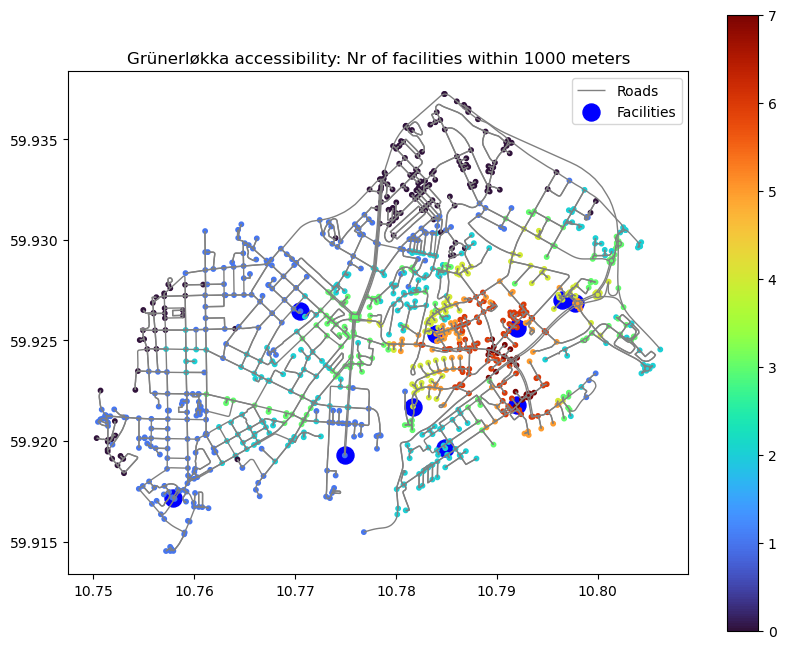

In [64]:
fig, ax = plt.subplots(figsize=(10,8))
plt.title('Grünerløkka accessibility: Nr of facilities within 1000 meters')
edges.plot(ax=ax, linewidth=1, edgecolor='gray', label='Roads') # Road network
facility_nodes.plot(ax=ax, color='b', label='Facilities', markersize=150) # Facilities
plt.scatter(gruner_pandana_network.nodes_df.x, gruner_pandana_network.nodes_df.y, 
            c=accessibility, s=10, cmap="turbo") # Accessibility to nr of facilities within 1000 meters
cb = plt.colorbar()
plt.legend(); plt.show()